In [ ]:
# default_exp models.ensembles

# models.ensembles
> API details.

In [ ]:
# export
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""
import numpy as np
import torch
from torch import nn
from fastrenewables.tabular.model import *
from fastrenewables.timeseries.model import *
from fastai.tabular.all import *
from torch.autograd import Variable
from sklearn.datasets import make_regression
from fastai.learner import *
from fastrenewables.utils_pytorch import *
import copy
from fastrenewables.timeseries.model import *
from fastrenewables.baselines import BayesLinReg, ELM
from fastrenewables.models.transfermodels import *
from fastrenewables.tabular.learner import *
from fastrenewables.timeseries.learner import *
from sklearn.base import BaseEstimator
import numpy as np

There are a number of different possibilities for ensembling/weighting in timeseries. The following functions cover those relevant for fastrenewables.

The most simple one, will we have $N$ predictions with a forecast horizon of 1 by $k$ ensemble members.
Respectively, the prediction has the shape $N\times k$ or alternatively $N\times k \times 1$. Or alternatively we have an ensemble weight for $N\times k \times t$, so for each forecast horizon and and sample we have an weight. 

In [ ]:
#export
def normalize_weight(ensemble_weight):
    """
    Let N be the number of samples, k the number of ensembles, and
    t be the forecast horizon.
    In case of an input array of dimension k, it is reshaped to k x 1, assuming a single forecast horizon.
    In case of a k x t array we normalize for each forecast horizon t acrross all ensmeble members.
    In case of Nxkxt we also normalise accross all members for each horizon.
    """
    
    if len(ensemble_weight.shape) == 1:
        ensemble_weight = ensemble_weight.reshape(len(ensemble_weight), 1)
            
    if len(ensemble_weight.shape) == 2:
        ensemble_weight = ensemble_weight/ensemble_weight.sum(0)
    elif len(ensemble_weight.shape) == 3:
        ensemble_weight = (ensemble_weight/ensemble_weight.sum(1)[:,np.newaxis,:])
        
    return ensemble_weight

In [ ]:
#export
def weight_preds(preds, ensemble_weight):
    """
        Weight the predictions by the ensemble weights, depeneding on the shape.
    """
    ensemble_weight = ensemble_weight
    if len(ensemble_weight.shape) == 1:
        ensemble_weight = ensemble_weight.reshape(len(ensemble_weight), 1)
    if len(preds.shape) == 1:
        preds = preds.reshape(len(preds), 1)
    if len(preds.shape) == 2:
        preds = preds[:,:,np.newaxis]
        
    if len(ensemble_weight.shape) == 2:
        preds = ((preds*ensemble_weight).sum(1))
    elif len(ensemble_weight.shape) == 3:
        preds = (preds*ensemble_weight).sum(1)
    return preds

The following tests cover the different scenarios.

In [ ]:
N,k,t = 100,3,1
yhat = np.random.random((N,k,t))
ensemble_weight = np.random.random((k,t))
test_close(normalize_weight(ensemble_weight).sum(0), np.array(1.))
normalized_weight = normalize_weight(ensemble_weight.ravel())
test_close(normalized_weight.sum(0), np.array(1.))
test_eq(weight_preds(yhat, normalized_weight).shape, (100,1))

N,k,t = 100,3,5
ensemble_weight = np.random.random((k,t))
yhat = np.random.random((N,k,t))
# when summing accross all, 
# the normalized weight should be equal to the number forecast horizons
normalized_weight = normalize_weight(ensemble_weight)
test_close(normalized_weight.sum(), t)
test_eq(weight_preds(yhat, normalized_weight).shape, (100,5))

N,k,t = 5,3,4
yhat = np.random.random((N,k,t))
ensemble_weight = np.random.random((N, k, t))
# for each forecast horizon for each samples it should sum up to one.
normalized_weight = normalize_weight(ensemble_weight)
test_close(normalized_weight.sum(1), np.ones((N,t)))
# we should get the weighted result by Nxt
test_eq(weight_preds(yhat, normalized_weight).shape, (5,4))


N,k,t = 40,2,1
yhat = np.random.random((N,k,t)).reshape((N,k))
ensemble_weight = np.random.random((k,t))
test_close(normalize_weight(ensemble_weight).sum(0), np.array(1.))
normalized_weight = normalize_weight(ensemble_weight.ravel())
test_eq(weight_preds(yhat, normalized_weight).shape, (40,1))

# Source Models

## Prep Data

In [ ]:
def generate_single_dataset(n_samples, start, end, bias, coef, noise_factor=0.3):

    X = np.random.uniform(low=start, high=end,size=n_samples)
    y = np.sin(X*coef*2*np.pi) + np.random.randn(X.shape[0])*noise_factor+bias
    
    return X,y

In [ ]:
def generate_all_tasks(n_samples=200):
    starts = [0,  0, 0]
    ends = [4.1,  3.9, 3.7]
    coefs = [3.4,  4, 4.5]
    biases = [0.1,  0.1, 0.1]
    n_samples = [n_samples, n_samples, n_samples]
    
    df_tasks = []
    for task_id in range(len(starts)):
        start, end, bias, coef = starts[task_id], ends[task_id], coefs[task_id], biases[task_id]
        X,y = generate_single_dataset(n_samples[task_id], start, end, bias, coef, noise_factor=0.05)
        df_task = pd.DataFrame({"X": X.ravel(), "y":y.ravel()})
        df_task["TaskID"] = task_id
        df_tasks.append(df_task)
    return pd.concat(df_tasks)

In [ ]:
def get_source_task(df):
    df_source =  df[(df.TaskID == 0) ]
    dls_source_01 = TabularDataLoaders.from_df(df_source, cont_names="X", y_names="y", 
                                     deivce="cpu", procs=Normalize, bs=10)
    
    df_source =  df[(df.TaskID == 1)]
    dls_source_02 = TabularDataLoaders.from_df(df_source, cont_names="X", y_names="y", 
                                     deivce="cpu", procs=Normalize, bs=10)
    
    return dls_source_01, dls_source_02
    
def get_target_task(df):
    df_target =  df[df.TaskID == 2]
    dls = TabularDataLoaders.from_df(df_target, cont_names="X", y_names="y", 
                                     deivce="cpu", procs=Normalize, bs=10)
    return dls

In [ ]:
df = generate_all_tasks()

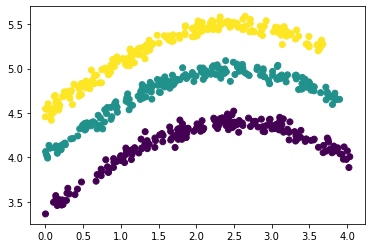

In [ ]:
plt.scatter(df.X, df.y, c=df.TaskID)

In [ ]:
dls_source_01, dls_source_02 = get_source_task(df)
dls_target = get_target_task(df)

## Train Source Models

In [ ]:
set_seed(41, reproducible=True)
source_model = MultiLayerPerceptron([1, 100, 50, 10, 1], use_bn=True, bn_cont=True)
learn_source_01 = Learner(dls_source_01, source_model, metrics=rmse)
learn_source_01.fit(10, lr=0.05)

epoch,train_loss,valid_loss,_rmse,time
0,6.432735,0.754278,0.868492,00:00
1,3.176492,0.607088,0.779158,00:00
2,1.826525,0.027260,0.165107,00:00
3,1.148280,0.009614,0.098048,00:00
4,0.762176,0.016209,0.127315,00:00
5,0.525207,0.021040,0.145051,00:00
6,0.372846,0.014523,0.120511,00:00
7,0.267032,0.009698,0.098478,00:00
8,0.196054,0.012621,0.112345,00:00
9,0.148374,0.030688,0.175180,00:00


In [ ]:
set_seed(456, reproducible=True)
source_model = MultiLayerPerceptron([1, 100, 50, 10, 1], use_bn=True, bn_cont=True)
learn_source_02 = Learner(dls_source_02, source_model, metrics=rmse)
learn_source_02.fit(15, lr=0.025)

epoch,train_loss,valid_loss,_rmse,time
0,18.773550,11.559833,3.399975,00:00
1,9.280488,0.499872,0.707016,00:00
2,5.413975,0.102577,0.320276,00:00
3,3.410022,0.014606,0.120856,00:00
4,2.250854,0.011857,0.108889,00:00
5,1.536420,0.016925,0.130095,00:00
6,1.074813,0.014082,0.118669,00:00
7,0.762232,0.014038,0.118481,00:00
8,0.548200,0.021880,0.147919,00:00
9,0.400647,0.023489,0.153260,00:00


In [ ]:
elm_source_model_01 = ELM(n_hidden=10, activations=np.sin, 
                          include_original_features=False,
                         prediction_model=BayesLinReg(alpha=100, beta=10, empirical_bayes=False))
elm_source_model_01 = elm_source_model_01.fit(dls_source_01.conts.values, dls_source_01.ys.values.ravel())

elm_source_model_02 = ELM(n_hidden=50, include_original_features=False,
                         prediction_model=BayesLinReg(alpha=1, beta=1, use_fixed_point=True))
elm_source_model_02 = elm_source_model_02.fit(dls_source_02.conts.values, dls_source_02.ys.values)

## Eval Source Model

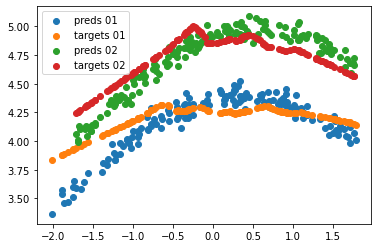

In [ ]:
targets, preds = learn_source_01.get_preds(ds_idx=0)
plt.scatter(dls_source_01.train_ds.items.X, preds, label="preds 01")
plt.scatter(dls_source_01.train_ds.items.X, targets, label="targets 01")

targets, preds = learn_source_02.get_preds(ds_idx=0)
plt.scatter(dls_source_02.train_ds.items.X, preds, label="preds 02")
plt.scatter(dls_source_02.train_ds.items.X, targets, label="targets 02")
plt.legend()
plt.show()

# Target

## Adapt source models

In [ ]:
# export
def update_single_model(model, dls):
    target_model = LinearTransferModel(
                    model, num_layers_to_remove=1, 
                    prediction_model=BayesLinReg(1, 1, use_fixed_point=True))
    
    target_learner = RenewableLearner(dls, target_model, loss_func=target_model.loss_func, metrics=rmse,)
    target_learner.dls[0].bs=len(target_learner.dls.train_ds)
    target_learner.fit(1)
    
    return target_learner.model

In [ ]:
target_model_01 = update_single_model(learn_source_01.model, dls_target)

epoch,train_loss,valid_loss,_rmse,time
0,0.000000,0.009757,0.098776,00:00


In [ ]:
target_model_02 = update_single_model(learn_source_02.model, dls_target)

epoch,train_loss,valid_loss,_rmse,time
0,0.000000,0.006020,0.077586,00:00


## Train Ensemble

### Helper Functions

In [ ]:
#export
def rank_by_evidence(cats, conts, targets, models, logme=True):
    evidences = np.zeros(len(models))
    for idx,model in enumerate(models):
        if isinstance(model, BaseEstimator):
            evidences[idx] = model.log_evidence(to_np(conts), to_np(targets), logme=logme)
        else:
            evidences[idx] = model.log_evidence(cats, conts, targets, logme=logme)
    sort_ids = evidences.argsort()[::-1]
    return evidences.reshape(len(models), 1), sort_ids

In [ ]:
# hide
models = [target_model_01, target_model_02]
cats, conts, targets = convert_to_tensor(dls_target.train_ds)
evidences, sort_ids = rank_by_evidence(cats, conts,targets, models)
# test_eq(sort_ids, np.array([1,0]))

In [ ]:
# export
def get_posterioirs(cats, conts, targets, models):
    posteriors = []
    ts_length = 1
    if len(conts.shape)==3:
        ts_length = conts.shape[2]
        
    for idx,model in enumerate(models):
        if isinstance(model, BaseEstimator):
            posterior = np.exp(model.log_posterior(to_np(conts), to_np(targets)))
        else:
            posterior = np.exp(model.log_posterior(cats, conts, targets))
        posteriors.append(posterior.reshape(-1,1))
    posteriors = np.concatenate(posteriors, axis=1)
    return posteriors.reshape(len(models),ts_length)

In [ ]:
# hide
models = [target_model_01, target_model_02]
cats, conts, targets = convert_to_tensor(dls_target.train_ds)
posteriors = get_posterioirs(cats, conts, targets,  models)
test_eq(posteriors.shape, (2,1))

In [ ]:
# export
def get_predictive_uncertainty(cats, conts, models):
    yhats,ystds = [], []
    ts_length = 1
    if len(conts.shape)==3:
        ts_length = conts.shape[2]
        
    for idx,model in enumerate(models):
        if isinstance(model, BaseEstimator):
            yhat, ystd = model.predict_proba(to_np(conts))
            yhats.append(yhat.reshape(-1,ts_length))
            ystds.append(ystd.reshape(-1,ts_length))
        else:
            yhat, ystd = model.predict_proba(cats, conts)
            yhats.append(to_np(yhat).reshape(-1,ts_length))
            ystds.append(to_np(ystd).reshape(-1,ts_length))

    #  TODO if this working for timersiers?
    yhats, ystds = np.concatenate(yhats, axis=1), np.concatenate(ystds, axis=1)
    yhats, ystds = yhats.reshape(len(conts),len(models),ts_length), ystds.reshape(len(conts),len(models),ts_length)
    y_uncertainty = 1/ystds
    
    return yhats, y_uncertainty

In [ ]:
# hide
models = [target_model_01, target_model_02]
cats, conts, targets = convert_to_tensor(dls_target.train_ds)
yhats, y_uncertainty = get_predictive_uncertainty(cats, conts, models)


In [ ]:
# export
def get_preds(cats, conts, models, convert_to_np=True):
    yhats, ystds = [], []
    ts_length = 1
    if len(conts.shape) == 3:
        ts_length = conts.shape[2]
    for idx, model in enumerate(models):
        if isinstance(model, BaseEstimator):
            yhat = model.predict(to_np(conts)).reshape(-1, ts_length)
            yhats.append(yhat)
        elif hasattr(model, "predict"):
            yhat = model.predict(cats, conts).reshape(-1, ts_length)
            if convert_to_np:
                yhat = to_np(yhat)
            yhats.append(yhat)
        elif hasattr(model, "forward"):
            yhat = model.forward(cats, conts).reshape(-1, ts_length)
            if convert_to_np:
                yhat = to_np(yhat)
            yhats.append(yhat)
        else:
            raise ValueError("Unknown prediction function.")
    if convert_to_np:
        yhats = np.concatenate(yhats, axis=1)
    else:
        yhats = torch.cat(yhats, axis=1)

    yhats = yhats.reshape(len(conts), len(models), ts_length)

    return yhats

### Bayesian Model Averaging

In [ ]:
# export
class BayesModelAveraing(nn.Module):
    def __init__(self, source_models, 
                 rank_measure="evidence", 
                 weighting_strategy="evidence",
                 n_best_models=-1,
                is_timeseries=False):
        """
            rank_measure [str]: either rmse or logevidence
            n_best_models [int]: the n best models w.r.t. rank_measure are taken into account. 
                                default -1 takes all models
        
        """
        super().__init__()
        self.source_models = np.array(source_models)
        self.rank_measure=rank_measure
        
        self.weighting_strategy = weighting_strategy
        self.n_best_models = n_best_models
        self.is_timeseries = is_timeseries
        
        # fake param so that it can be used with pytorch trainers
        self.fake_param=nn.Parameter(torch.zeros((1,1), dtype=torch.float))
        self.fake_param.requires_grad =True
        
        self.conversion_to_tensor = convert_to_tensor_ts if self.is_timeseries else convert_to_tensor
        
        self.ensemble_weights = None
   
    def fit_tensors(self, cats, conts, targets):
        if self.training:
            if self.rank_measure == "evidence":
                self.rank_measure_values, self.sord_ids = rank_by_evidence(
                    cats, conts, targets, self.source_models
                )
            else:
                raise NotImplemented

            if self.n_best_models != -1:
                self.source_models = self.source_models[
                    self.sord_ids[0 : self.n_best_models]
                ]
                self.rank_measure_values = self.rank_measure_values[
                    self.sord_ids[0 : self.n_best_models]
                ]

        if self.weighting_strategy == "evidence":
            self.ensemble_weights, _ = rank_by_evidence(
                cats, conts, targets, self.source_models
            )

        elif self.weighting_strategy == "posterior":
            self.ensemble_weights = get_posterioirs(
                cats, conts, targets, self.source_models
            )

        if self.weighting_strategy != "uncertainty":
            self.ensemble_weights = normalize_weight(self.ensemble_weights)

    def fit(self, dls):
        cats, conts, targets = self.conversion_to_tensor(dls.train_ds)
        self.fit_tensors(cats, conts, targets)
        
            
    def _predict(self, cats, conts):
        if self.weighting_strategy=="uncertainty":
            yhat, y_uncertainty = get_predictive_uncertainty(cats, conts, self.source_models)
            if len(y_uncertainty.shape) == 2:
                y_uncertainty = y_uncertainty[:,:, np.newaxis]
                
            self.ensemble_weights = normalize_weight(y_uncertainty)
        else:
            yhat = get_preds(cats, conts, self.source_models)
        
        yhat = weight_preds(yhat, self.ensemble_weights)
        
        return yhat
    
    def forward(self, cats, conts):
        yhat = self._predict(cats, conts)
        
        return yhat

    def predict(self, dls, ds_idx=0):
        ds = dls.train_ds
        if ds_idx==1:
            ds = dls.valid_ds
        
        cats, conts, _ = self.conversion_to_tensor(ds)
            
        yhat = self._predict(cats, conts)
        
        return yhat   
    
    def log_evidence(self, dls, ds_idx=0,logme=False):
        ds = dls.train_ds
        if ds_idx==1:
            ds = dls.valid_ds
        
        cats, conts, targets = self.conversion_to_tensor(ds)
        evidences, _ = rank_by_evidence(cats, conts, targets, self.source_models, logme=logme)
        
        return evidences.mean()
        

In [ ]:
bma_model = BayesModelAveraing(source_models=[target_model_01, target_model_02], 
                               weighting_strategy='evidence',
                               n_best_models=-1)
bma_model.fit(dls_target)
cats, conts, targets = convert_to_tensor(dls_target.valid_ds)
yhat = bma_model.predict(dls_target, ds_idx=1).shape
((targets.ravel()-bma_model.predict(dls_target, ds_idx=1).ravel())**2).mean()**0.5

tensor(0.0842, dtype=torch.float64)

In [ ]:
bma_model = BayesModelAveraing(source_models=[target_model_01, target_model_02], 
                               weighting_strategy='posterior',
                               n_best_models=-1)
bma_model.fit(dls_target)
cats, conts, targets = convert_to_tensor(dls_target.valid_ds)
yhat = bma_model.predict(dls_target, ds_idx=1).shape
((targets.ravel()-bma_model.predict(dls_target, ds_idx=1).ravel())**2).mean()**0.5

tensor(0.0776, dtype=torch.float64)

In [ ]:
bma_model = BayesModelAveraing(source_models=[target_model_01, target_model_02], 
                               weighting_strategy='uncertainty',
                               n_best_models=-1)
bma_model.fit(dls_target)
cats, conts, targets = convert_to_tensor(dls_target.valid_ds)
yhat = bma_model.predict(dls_target, ds_idx=1)
((targets.ravel()-yhat.ravel())**2).mean()**0.5

tensor(0.0839)

We can also calculate the evidence of the ensemble.

In [ ]:
bma_model.log_evidence(dls_target, ds_idx=1)

32.80098555682608

In [ ]:
bma_model = BayesModelAveraing(source_models=[elm_source_model_01, elm_source_model_02], 
                               weighting_strategy='evidence',
                               n_best_models=-1)
bma_model.fit(dls_target)
cats, conts, targets = convert_to_tensor(dls_target.valid_ds)
yhat = bma_model.predict(dls_target, ds_idx=1)
((targets.ravel()-yhat.ravel())**2).mean()**0.5

tensor(1.2086, dtype=torch.float64)

### Coopetitive Soft Gating

In [ ]:
# export
def squared_error(y,yhat):
    return (y-yhat)**2

In [ ]:
#export
def soft_gating(errors, eta, eps=1e-9):
    errors_sum = errors.sum(0)+eps
    res = (errors_sum/(errors**eta))
    return res/res.sum()

In [ ]:
# export
# hide
def _flatten_ts(x):
    n_samples, n_features, ts_length = x.shape
    
    if isinstance(x, np.ndarray):
        x = x.swapaxes(1,2)
    else:
        x = x.permute(0,2,1)
    x = x.reshape(n_samples*ts_length, n_features)
    return x

def _unflatten_to_ts(x, ts_length, n_features):
    x = x.reshape(-1, ts_length, n_features)
    if isinstance(x, np.ndarray):
        x = x.swapaxes(1,2)
    else:
        x = x.permute(0,2,1)
    
    return x

In [ ]:
# export
def create_error_matrix(targets, preds, error_function=squared_error):
    """
        N=#samples, k=#ensembles, t=forecast horizon
        targets needs to be of size Nxt or Nx1xt
        yhat needs to be of shape Nxkxt
    """
    # shape N --> Nxkxt    
    if len(targets.shape)==1:
        targets = targets.reshape(-1,1,1)
        
    # shape Nxt --> Nxkxt 
    if len(targets.shape)==2:
        # 1 is so that we can brodcast accross k ensembles
        targets = targets.reshape(len(targets), 1, -1)
        
    # shape N --> Nxkxt    
    if len(preds.shape)==1:      
        preds = preds.reshape(-1,1,1)
        
    # shape Nxk --> Nxkxt 
    if len(preds.shape)==2: 
        # 1 is for a single forecast horizon
        preds = preds.reshape(len(preds), preds.shape[1],1)
    error_matrix = error_function(targets, preds)
    
    if error_function == squared_error:
        error_matrix = error_matrix**0.5
    
    if not isinstance(error_matrix, np.ndarray):
        error_matrix = to_np(error_matrix)
        
    return error_matrix

In [ ]:
N,k,t = 2,4,3 
targets = np.random.random((N,t))
yhat = np.random.random((N,k,t))
test_eq(create_error_matrix(targets, yhat).shape, (N,k,t))

N,k,t = 2,4,3 
targets = np.random.random((N,1,t))
yhat = np.random.random((N,k,t))
test_eq(create_error_matrix(targets, yhat).shape, (N,k,t))

N,k,t = 2,4,3 
targets = np.random.random((N))
yhat = np.random.random((N,k,t))
test_eq(create_error_matrix(targets, yhat).shape, (N,k,t))

N,k,t = 2,4,1 
targets = np.random.random((N))
yhat = np.random.random((N,k))
test_eq(create_error_matrix(targets, yhat).shape, (N,k,t))

In [ ]:
# export
def get_global_weight(error_matrix, eta=1):
    """expected to be of shape n_samples x n_ensembles x forecast_horizon """
    # average accross all forecast horizon and samples
    # either via error_matrix.mean(0).mean(1) or error_matrix.mean(2).mean(0)

    global_weight =  error_matrix.mean(0).mean(1)
    
    return soft_gating(global_weight.reshape(-1,1), eta)

In [ ]:
N,k,t = 10,4,3
targets = np.random.random((N,t))
yhat = np.random.random((N,k,t))
em = create_error_matrix(targets, yhat)
test_eq(get_global_weight(em).shape, (k,1))

In [ ]:
# export
def get_timedependent_weight(error_matrix, eta=1):
    """expected to be of shape n_samples x n_ensembles x forecast_horizon """
    # average accross all samples
    N,k,t =error_matrix.shape
    time_depentent_weight =  error_matrix.mean(0)

#     if not isinstance(time_depentent_weight, np.ndarray):
#             time_depentent_weight = to_np(time_depentent_weight)
    
    for t_i in range(t):
        time_depentent_weight[:,t_i] = soft_gating(time_depentent_weight[:,t_i], eta)

            
    return time_depentent_weight

In [ ]:
test_eq(get_timedependent_weight(em).shape, (k,t))

In [ ]:
# export
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.utils.validation import check_is_fitted
def simple_local_error_estimator(param_dict = {"n_components":5, "n_neighbors": 5}):
    pipe = Pipeline([('pca', PCA(n_components=param_dict["n_components"])), 
                     ('knn', KNeighborsRegressor(n_neighbors=param_dict["n_neighbors"]))])
    return pipe

def get_local_weight(conts, error_matrix, error_expectation_regressor, eta=1):
    N,k,t = error_matrix.shape
    
    if len(conts.shape)==3:
        conts=_flatten_ts(conts)
    
    if not isinstance(conts,np.ndarray):
        conts = to_np(conts)
        
    # todo check timeseries that is the same for each timestep
    local_error_expectation = error_expectation_regressor.predict(conts)
    
    local_error_expectation = _unflatten_to_ts(local_error_expectation, 
                                               ts_length=t, n_features=k)
            
    # we should have an error matrix of shape Nxk
#     for n in range(len(local_error_expectation)):
#         local_error_expectation[n,:] = soft_gating(local_error_expectation[n,], eta)
            
    return local_error_expectation

In [ ]:
cats, conts, targets = convert_to_tensor(dls_target.valid_ds)

In [ ]:
preds_01 = target_model_01.predict(cats, conts)
preds_02 = target_model_02.predict(cats, conts)
preds_comb = np.concatenate([preds_01, preds_02], axis=1)
error_matrix = create_error_matrix(targets, preds_comb)

In [ ]:
error_expectation_regressor = simple_local_error_estimator(param_dict = {"n_components":1, "n_neighbors": 5})

In [ ]:
error_expectation_regressor = error_expectation_regressor.fit(conts, error_matrix.reshape(-1,error_matrix.shape[1]))

In [ ]:
local_weight = get_local_weight(conts, error_matrix, error_expectation_regressor)

In [ ]:
_tmp = get_local_weight(conts, error_matrix, error_expectation_regressor)

In [ ]:
# export

def turnOffTrackingStats(module):
        if hasattr(module, "track_running_stats"):
            module.track_running_stats = False
        for childMod in module.children():
            turnOffTrackingStats(childMod)

            
class CSGE(nn.Module):
    def __init__(self, source_models,
                       eta_global=10, eta_time=10, eta_local=10,
                 is_timeseries_model=False, 
                 is_timeseries_data=False,
                 use_elm=True,
                 n_hidden=200,
                 ts_length=1):
        """
        """
        super().__init__()
        self.source_models = np.array(source_models)
        self.is_timeseries_data = is_timeseries_data
        self.is_timeseries_model = is_timeseries_model
        self.error_expectation_regressor = \
            LocalErrorPredictor(len(source_models), use_elm=use_elm, n_hidden=n_hidden)
         
        self.conversion_to_tensor = convert_to_tensor_ts if self.is_timeseries_data else convert_to_tensor
        
        self.ts_length = ts_length
        self.error_matrix = None
        self.global_weights = None
        self.timedependent_weights = None
        self.local_weights = None
        
        self.eta_global = nn.Parameter(torch.Tensor([eta_global]))
        self.eta_local = nn.Parameter(torch.Tensor([eta_local]))
        self.eta_time = nn.Parameter(torch.Tensor([eta_time]))
   
#     def setup_complete_data(self, cats, conts, targets):
#         if len(conts.shape) == 3:
#             # is already timeseries data
#             conts_non_ts = _flatten_ts(conts)
#             if len(cats)>0 and cats.numel() != 0:
#                 cats_non_ts = _flatten_ts(cats)
#             else:
#                 cats_non_ts = cats
#             targets_non_ts = _flatten_ts(targets)
#         else:
#             cats_non_ts, conts_non_ts, targets_non_ts = cats, conts, targets
#             conts = _unflatten_to_ts(conts, self.ts_length, conts.shape[1])
#             targets = _unflatten_to_ts(targets, self.ts_length, targets.shape[1])
#             if len(cats)>0 and cats.numel() != 0:
#                 cats_non_ts = _unflatten_to_ts(cats, self.ts_length, cats.shape[1])


#         if self.is_timeseries_model:
#             preds = get_preds(cats, conts, self.source_models, convert_to_np=False)
#         else:
#             preds = get_preds(cats_non_ts, conts_non_ts, self.source_models, convert_to_np=False)
#             preds = _unflatten_to_ts(
#                 preds, self.ts_length, len(self.source_models)
#             )  
#         self.cats, self.conts, self.targets = cats, conts, targets
#         self.cats_non_ts, self.conts_non_ts, self.targets_non_ts = cats_non_ts, conts_non_ts, targets_non_ts
#         self.targets, self.preds = targets, preds

    def setup_complete_data(self, cats, conts, targets=None):
        targets_non_ts = None
        if len(conts.shape) == 3:
            # is already timeseries data
            conts_non_ts = _flatten_ts(conts)
            if len(cats)>0 and cats.numel() != 0:
                cats_non_ts = _flatten_ts(cats)
            else:
                cats_non_ts = cats
            if targets is not None:  targets_non_ts = _flatten_ts(targets)
        else:
            cats_non_ts, conts_non_ts, targets_non_ts = cats, conts, targets
            conts = _unflatten_to_ts(conts, self.ts_length, conts.shape[1])
            if targets is not None: targets = _unflatten_to_ts(targets, self.ts_length, targets.shape[1])
            if len(cats)>0 and cats.numel() != 0:
                cats_non_ts = _unflatten_to_ts(cats, self.ts_length, cats.shape[1])


        if self.is_timeseries_model:
            preds = get_preds(cats, conts, self.source_models, convert_to_np=False)
        else:
            preds = get_preds(cats_non_ts, conts_non_ts, self.source_models, convert_to_np=False)
            preds = _unflatten_to_ts(
                preds, self.ts_length, len(self.source_models)
            )  
        self.cats, self.conts, self.targets = cats, conts, targets
        self.cats_non_ts, self.conts_non_ts, self.targets_non_ts = cats_non_ts, conts_non_ts, targets_non_ts
        self.targets, self.preds = targets, preds
        

    def fit(self, dls, ds_idx=0, n_epochs=1):
        turnOffTrackingStats(self)
        if ds_idx == 0:
            ds = dls.train_ds
        else:
            ds = dls.valid_ds
            
        cats, conts, targets = self.conversion_to_tensor(ds)
        
        # we do an initial fit to setup everything
        with torch.no_grad():
            self.setup_complete_data(cats, conts, targets)
            # TODO: fit local predictors
            self.error_matrix = torch.tensor(create_error_matrix(self.targets, self.preds))
            # update local, global, and timedependent weight
        
            self.global_weights = get_global_weight(self.error_matrix, self.eta_global)
            
            self.error_expectation_regressor.fit(self.conts, self.error_matrix)

            self.local_weight = get_local_weight(
                self.conts_non_ts,
                self.error_matrix,
                self.error_expectation_regressor,
                eta=self.eta_local,
            )
            
            if self.ts_length>1 or self.is_timeseries_data:
                self.time_dependent_weights = get_timedependent_weight(
                    self.error_matrix, self.eta_time
                )
        
    def calc_final_weights(self):
        if self.ts_length>1 or self.is_timeseries_data: 
            final_weights = self.global_weights*self.time_dependent_weights
        else:
            final_weights = self.global_weights
        final_weights = self.global_weights
            
        final_weights = normalize_weight(final_weights)
        
        final_weights = final_weights*self.local_weights
            
        self.final_weights = final_weights
        self.final_weights = normalize_weight(final_weights)
        
        return self.final_weights
            
    def _predict(self, cats, conts):
        yhat = get_preds(cats, conts, self.source_models, convert_to_np=False)  
        
        if self.ts_length != 1 and not self.is_timeseries_data:
            yhat = _unflatten_to_ts(yhat, self.ts_length, yhat.shape[1])
#         yhat = torch.tensor(yhat)
        
        self.local_weights = get_local_weight(conts, self.error_matrix, 
                                              self.error_expectation_regressor, 
                                              )
        
        final_weights = self.calc_final_weights()
        
        yhat = weight_preds(yhat, final_weights)
        
        return yhat
    
#     def forward(self, cats, conts):
#         self.global_weights = get_global_weight(self.error_matrix, self.eta_global)
            
#         self.local_weight = get_local_weight(
#             self.conts_non_ts,
#             self.error_matrix,
#             self.error_expectation_regressor,
#             eta=self.eta_local,
#         )

#         if self.ts_length>1 or self.is_timeseries_data:
#             self.time_dependent_weights = get_timedependent_weight(
#                 self.error_matrix, self.eta_time
#             )

#         yhat = self._predict(cats, conts)
        
#         return yhat

    def forward(self, cats, conts):
        self.setup_complete_data(cats, conts)
        self.global_weights = get_global_weight(self.error_matrix, self.eta_global)

        self.local_weights = get_local_weight(
            self.conts_non_ts,
            self.error_matrix,
            self.error_expectation_regressor,
            eta=self.eta_local,
        )

        self.local_weights = Variable(self.local_weights)
        self.local_weights.requires_grad = True

        def vSoftGate(t, eta, eps=1e-18):
            t = torch.sum(t, dim=1).reshape(t.shape[0], 1) / (t ** eta + eps)
            return t / torch.sum(t, dim=1).reshape(t.shape[0], 1)

        # TODO as Variable before applying soft gating formula
        
        # we should have an error matrix of shape Nxk
        new_local_weights = []
        for n in range(len(self.local_weights)):
            new_local_weights.append(
                soft_gating(self.local_weights[n,], self.eta_local)[np.newaxis, :, :]
            )
        self.local_weights = torch.cat(new_local_weights)

        # TODO as Variable before applying soft gating formula
        if self.ts_length > 1 or self.is_timeseries_data:
            self.time_dependent_weights = get_timedependent_weight(
                self.error_matrix, self.eta_time
            )

        yhat = (
            self.preds
        )  # get_preds(cats, conts, self.source_models, convert_to_np=False)

        if self.ts_length != 1 and not self.is_timeseries_data:
            yhat = _unflatten_to_ts(yhat, self.ts_length, yhat.shape[1])

        final_weights = self.global_weights * self.local_weights

        final_weights = normalize_weight(final_weights)
        

        # print(yhat.shape, final_weights.shape)

        yhat = weight_preds(yhat, final_weights)

        # yhat = self._predict(cats, conts)

        return yhat

    def predict(self, dls, ds_idx=0):
        ds = dls.train_ds
        if ds_idx==1:
            ds = dls.valid_ds
        
        cats, conts, targets = self.conversion_to_tensor(ds)
            
        yhat = self._predict(cats, conts)
        
        return yhat, targets   

class LocalErrorPredictor(BaseEstimator):
    def __init__(self, n_models=1, use_elm=True, n_hidden=200):
        self.n_models = n_models
        self.use_elm = use_elm
        self.n_hidden = n_hidden
    
    def fit(self, conts, errors):
        
        if len(conts.shape)==3:
            conts=_flatten_ts(conts)
            
        if len(errors.shape)==3:
            errors=_flatten_ts(errors)
    
        if not isinstance(conts,np.ndarray):
            conts = to_np(conts)
            
        if not isinstance(errors,np.ndarray):
            errors = to_np(errors)
        
        self.models = []
        for idx in range(self.n_models):
            model = BayesLinReg(use_fixed_point=True)
            if self.use_elm:
                model = ELM(n_hidden=self.n_hidden, prediction_model=model)
            model = model.fit(conts, errors[:,idx])
            self.models.append(model)
            
    def predict(self, conts):
        if len(conts.shape)==3:
            conts=_flatten_ts(conts)
            
        if not isinstance(conts,np.ndarray):
            conts = to_np(conts)
            
        preds = []
        for model in self.models:
            pred = model.predict(conts)
            preds.append(torch.tensor(pred).reshape(-1,1))
            
        preds = torch.cat(preds, axis=1)
        
        return preds

In [ ]:
for eta in [0.8,0.9,1,2,3,4,5,6,7,8,9,10,20]:
    csge_model = CSGE(source_models=[target_model_01, target_model_02],
                     eta_global=eta, eta_local=eta, eta_time=eta)
    
    csge_model.fit(dls_target, ds_idx=1)
    
    yhat, targets = csge_model.predict(dls_target, ds_idx=1)
    print(eta, ((targets.ravel()-yhat.ravel())**2).mean()**0.5)

0.8 tensor(0.0871, dtype=torch.float64)
0.9 tensor(0.0871, dtype=torch.float64)
1 tensor(0.0868, dtype=torch.float64)
2 tensor(0.0857, dtype=torch.float64)
3 tensor(0.0846, dtype=torch.float64)
4 tensor(0.0837, dtype=torch.float64)
5 tensor(0.0827, dtype=torch.float64)
6 tensor(0.0818, dtype=torch.float64)
7 tensor(0.0811, dtype=torch.float64)
8 tensor(0.0805, dtype=torch.float64)
9 tensor(0.0800, dtype=torch.float64)
10 tensor(0.0796, dtype=torch.float64)
20 tensor(0.0778, dtype=torch.float64)


# Check for real world timeseries data

## Data Preparation

In [ ]:
from fastrenewables.timeseries.core import *
from fastrenewables.tabular.core import *
from fastrenewables.timeseries.data import *
from fastrenewables.timeseries.model import *
from fastrenewables.timeseries.learner import *

In [ ]:
cont_names = ['T_HAG_2_M', 'RELHUM_HAG_2_M', 'PS_SFC_0_M', 'ASWDIFDS_SFC_0_M',
       'ASWDIRS_SFC_0_M', 'WindSpeed58m',
       'SinWindDirection58m', 'CosWindDirection58m', 'WindSpeed60m']
cat_names = ['Hour']

def get_dls(y_names="PowerGeneration"):
    pd.options.mode.chained_assignment=None
    dls_source0 = RenewableTimeSeriesDataLoaders.from_files(glob.glob("../data/*.h5")[0], 
                                                y_names=y_names, 
                                                cat_names=cat_names, 
                                                cont_names=cont_names,
                                                pre_procs=[CreateTimeStampIndex(index_col_name="TimeUTC"),
                                                             AddSeasonalFeatures(as_cont=False),
                                                             FilterInconsistentSamplesPerDay], 
                                                procs=[Categorify, Normalize], 
                                                bs=12,
                                                y_block=RegressionBlock(),
                                                )
    dls_source1 = RenewableTimeSeriesDataLoaders.from_files(glob.glob("../data/*.h5")[1], 
                                                y_names=y_names, 
                                                cat_names=cat_names, 
                                                cont_names=cont_names,
                                                pre_procs=[CreateTimeStampIndex(index_col_name="TimeUTC"),
                                                             AddSeasonalFeatures(as_cont=False),
                                                             FilterInconsistentSamplesPerDay], 
                                                procs=[Categorify, Normalize], 
                                                bs=12,
                                                y_block=RegressionBlock(),
                                                )
    
    dls_target = RenewableTimeSeriesDataLoaders.from_files(glob.glob("../data/*.h5")[2], 
                                                y_names=y_names, 
                                                cat_names=cat_names, 
                                                cont_names=cont_names,
                                                pre_procs=[CreateTimeStampIndex(index_col_name="TimeUTC"),
                                                           FilterYear(year=2020), 
                                                             AddSeasonalFeatures(as_cont=False),
                                                             FilterInconsistentSamplesPerDay, 
                                                           FilterMonths(months=[1,2,3,4])], 
                                                procs=[Categorify, Normalize], 
                                                bs=12,
                                                y_block=RegressionBlock(),
                                                )
    
    return dls_source0,dls_source1,dls_target


## Timeseries source model

In [ ]:
set_seed(23, reproducible=True)
dls_source0, dls_source1,dls_target = get_dls()
ann_structure = [len(cont_names), 10, 5, 1]

In [ ]:
set_seed(23, reproducible=True)
learn_source0 = renewable_timeseries_learner(dls_source0, layers=ann_structure, metrics=rmse)
learn_source0.fit(10)

epoch,train_loss,valid_loss,_rmse,time
0,0.075959,0.049644,0.222810,00:00
1,0.050632,0.028458,0.168695,00:00
2,0.036488,0.021525,0.146716,00:00
3,0.028245,0.019161,0.138424,00:00
4,0.023330,0.017868,0.133670,00:00
5,0.020304,0.016956,0.130215,00:00
6,0.018368,0.016351,0.127869,00:00
7,0.017070,0.015937,0.126243,00:00
8,0.016186,0.015668,0.125171,00:00
9,0.015559,0.015452,0.124304,00:00


In [ ]:
set_seed(12345, reproducible=True)
learn_source1 = renewable_timeseries_learner(dls_source1, layers=ann_structure, metrics=rmse)
learn_source1.fit(10)

epoch,train_loss,valid_loss,_rmse,time
0,0.041709,0.029697,0.172329,00:00
1,0.032322,0.023872,0.154507,00:00
2,0.027287,0.022111,0.148696,00:00
3,0.024335,0.020824,0.144304,00:00
4,0.022340,0.020273,0.142383,00:00
5,0.021012,0.019778,0.140634,00:00
6,0.020052,0.019471,0.139538,00:00
7,0.019335,0.019351,0.139109,00:00
8,0.018797,0.019249,0.138742,00:00
9,0.018372,0.019146,0.138369,00:00


## Timeseries Target Models and Bayesian Model Averaging

In [ ]:
target_model0 = LinearTransferModel(learn_source0.model, 1, 
                           reduce_layers_tcn_model, 
                           use_original_weights=False,
                        prediction_model=BayesLinReg(1, 1, empirical_bayes=False,use_fixed_point=True),
                                  )

target_learner0 = RenewableTimeseriesLearner(dls_target, target_model0, loss_func=target_model0.loss_func, metrics=rmse,)
target_learner0.dls[0].bs=len(target_learner0.dls.train_ds)
target_learner0.fit(1)

epoch,train_loss,valid_loss,_rmse,time
0,0.000000,0.019864,0.140941,00:00


In [ ]:
target_model1 = LinearTransferModel(learn_source1.model, 1, 
                           reduce_layers_tcn_model, 
                           use_original_weights=False,
                        prediction_model=BayesLinReg(1, 1, use_fixed_point=True),
                                  )

target_learner1 = RenewableTimeseriesLearner(dls_target, target_model1, loss_func=target_model1.loss_func, metrics=rmse,)
target_learner1.dls[0].bs=len(target_learner1.dls.train_ds)
target_learner1.fit(1)

epoch,train_loss,valid_loss,_rmse,time
0,0.000000,0.018835,0.137241,00:00


In [ ]:
bma_model = BayesModelAveraing(source_models=[target_learner0.model, target_learner1.model], 
                               weighting_strategy='evidence',is_timeseries=True,
                               n_best_models=-1)
bma_model.fit(dls_target)
cats, conts, targets = convert_to_tensor_ts(dls_target.valid_ds)
yhat = bma_model.predict(dls_target, ds_idx=1)
((targets.ravel()-bma_model.predict(dls_target, ds_idx=1).ravel())**2).mean()**0.5

tensor(0.1244, dtype=torch.float64)

In [ ]:
bma_model = BayesModelAveraing(source_models=[target_learner0.model, target_learner1.model], 
                               weighting_strategy='posterior',is_timeseries=True,
                               n_best_models=-1)
bma_model.fit(dls_target)
cats, conts, targets = convert_to_tensor_ts(dls_target.valid_ds)
yhat = bma_model.predict(dls_target, ds_idx=1)
((targets.ravel()-bma_model.predict(dls_target, ds_idx=1).ravel())**2).mean()**0.5

tensor(0.1291, dtype=torch.float64)

In [ ]:
bma_model = BayesModelAveraing(source_models=[target_learner0.model, target_learner1.model], 
                               weighting_strategy='uncertainty',is_timeseries=True,
                               n_best_models=-1)
bma_model.fit(dls_target)
cats, conts, targets = convert_to_tensor_ts(dls_target.valid_ds)
yhat = bma_model.predict(dls_target, ds_idx=1)
((targets.ravel()-bma_model.predict(dls_target, ds_idx=1).ravel())**2).mean()**0.5

tensor(0.1250)

## CSGE on Timeseries

In [ ]:
for eta in [0.8,0.9,1,2,3,4,5,6,7,8,9,10]:
    csge_model = CSGE(source_models=[target_learner0.model, target_learner1.model],
                     eta_global=eta, eta_local=eta, eta_time=-10,
                      is_timeseries_data=True, is_timeseries_model=True, 
                      ts_length=24)

    csge_model.fit(dls_target, ds_idx=1)
   
    yhat, target = csge_model.predict(dls_target, ds_idx=1)
    print(eta, ((targets.ravel()-yhat.ravel())**2).mean()**0.5)

0.8 tensor(0.4185, dtype=torch.float64)
0.9 tensor(0.1262, dtype=torch.float64)
1 tensor(0.1265, dtype=torch.float64)
2 tensor(0.1392, dtype=torch.float64)
3 tensor(0.1261, dtype=torch.float64)
4 tensor(0.1262, dtype=torch.float64)
5 tensor(0.1285, dtype=torch.float64)
6 tensor(0.1268, dtype=torch.float64)
7 tensor(0.1258, dtype=torch.float64)
8 tensor(0.1261, dtype=torch.float64)
9 tensor(1.2204, dtype=torch.float64)
10 tensor(0.1276, dtype=torch.float64)


In [ ]:
for eta in [0.8,0.9,1,2,3,4,5,6,7,8,9,10]:
    csge_model = CSGE(source_models=[learn_source0.model, learn_source1.model],
                     eta_global=eta, eta_local=eta, eta_time=-10,
                      is_timeseries_data=True, is_timeseries_model=True, 
                      ts_length=24)

    csge_model.fit(dls_target, ds_idx=1)
    
    yhat, targets = csge_model.predict(dls_target, ds_idx=1)
    print(eta, ((targets.ravel()-yhat.ravel())**2).mean()**0.5)

0.8 tensor(0.1224, dtype=torch.float64, grad_fn=<PowBackward0>)
0.9 tensor(0.1223, dtype=torch.float64, grad_fn=<PowBackward0>)
1 tensor(0.1223, dtype=torch.float64, grad_fn=<PowBackward0>)
2 tensor(0.1207, dtype=torch.float64, grad_fn=<PowBackward0>)
3 tensor(0.1197, dtype=torch.float64, grad_fn=<PowBackward0>)
4 tensor(0.1183, dtype=torch.float64, grad_fn=<PowBackward0>)
5 tensor(0.1173, dtype=torch.float64, grad_fn=<PowBackward0>)
6 tensor(0.1165, dtype=torch.float64, grad_fn=<PowBackward0>)
7 tensor(0.1157, dtype=torch.float64, grad_fn=<PowBackward0>)
8 tensor(0.1151, dtype=torch.float64, grad_fn=<PowBackward0>)
9 tensor(0.1145, dtype=torch.float64, grad_fn=<PowBackward0>)
10 tensor(0.1141, dtype=torch.float64, grad_fn=<PowBackward0>)
